In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_files = []
update_list = []

## Helper functions

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [9]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [10]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [11]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [12]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [13]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
        
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [14]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [15]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [16]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [17]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
    print(sel_cl)
    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [18]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [19]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [20]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read cell type hierarchy

In [21]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [22]:
search_id = 'niobium-cerium-barium'

Retrieve files stored in our HISE project store

In [23]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [24]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [25]:
search_df['AIFI_L3'].tolist()

['CM CD4 T cell',
 'Core naive CD4 T cell',
 'GZMB- CD27- EM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'ISG+ memory CD4 T cell',
 'ISG+ naive CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'SOX4+ naive CD4 T cell']

## Review CM CD4 T cell

### Proposed updates

- Remove high CD3D- clusters as low quality  
- Remove high CD8A cluster (12) as Mislabeled  
    - Re-cluster with CD8 cells to assign final clusters in a separate process

In [26]:
cell_type = 'CM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [27]:
type_uuid

'f3a014af-7e16-4671-9da8-01e603bea5ed'

In [28]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [29]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

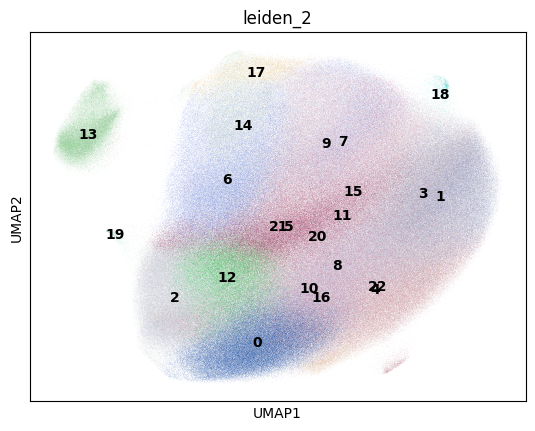

In [30]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

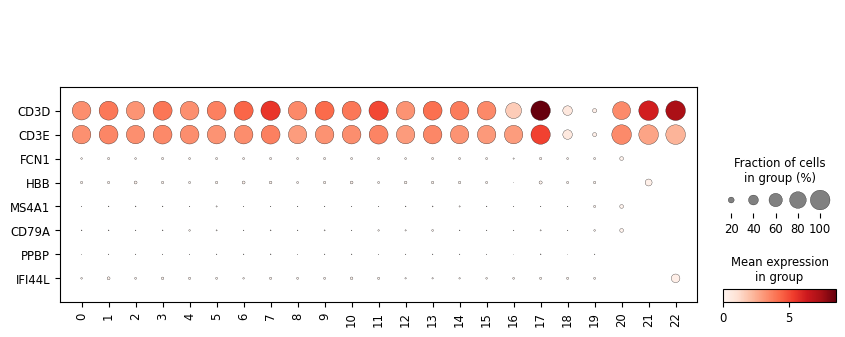

In [31]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

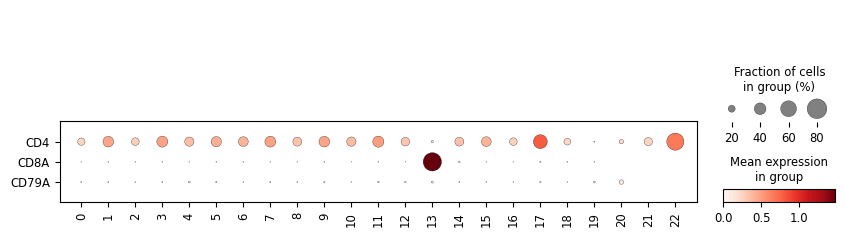

In [32]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD4','CD8A','CD79A'], swap_axes = True)

### CD3D- Selection

Filtering

In [33]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'below', 0.5, 'leiden_2'
)
n_removed

['18', '19']


4649

Reason

In [34]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Low quality']
    }
)
update_list.append(update_df)

### CD8A Selection

Removal

In [35]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['13']


61331

Reason

In [36]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8+ cells']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [37]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; 

IOStream.flush timed out


UMAP; 

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Renormalizing


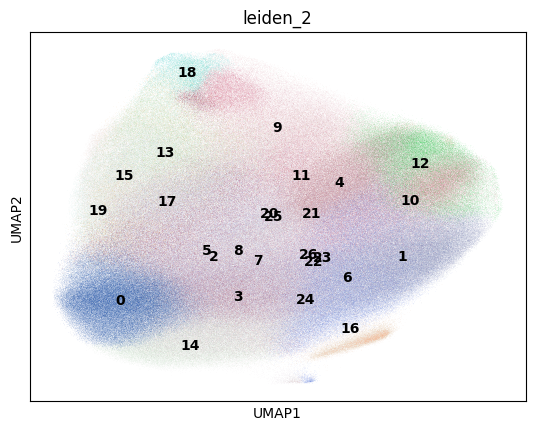

In [38]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [39]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review Core naive CD4 T cell

### Proposed updates

- Remove high HBB cluster (16) as Erythrocyte doublet  
- Remove low marker expression cluster (15) as low-quality

In [40]:
cell_type = 'Core naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [41]:
type_uuid

'abfe5e61-ee6d-47cf-906b-faff06c2ce67'

In [42]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [43]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

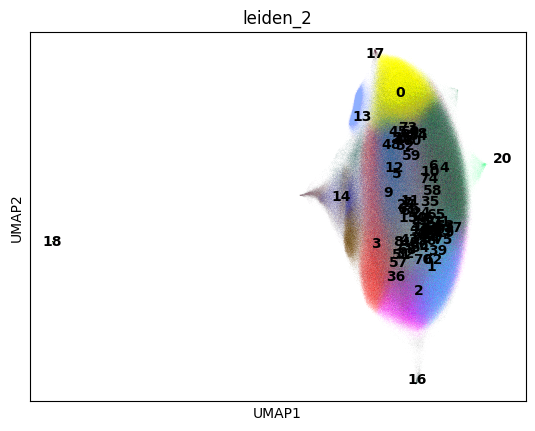

In [44]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

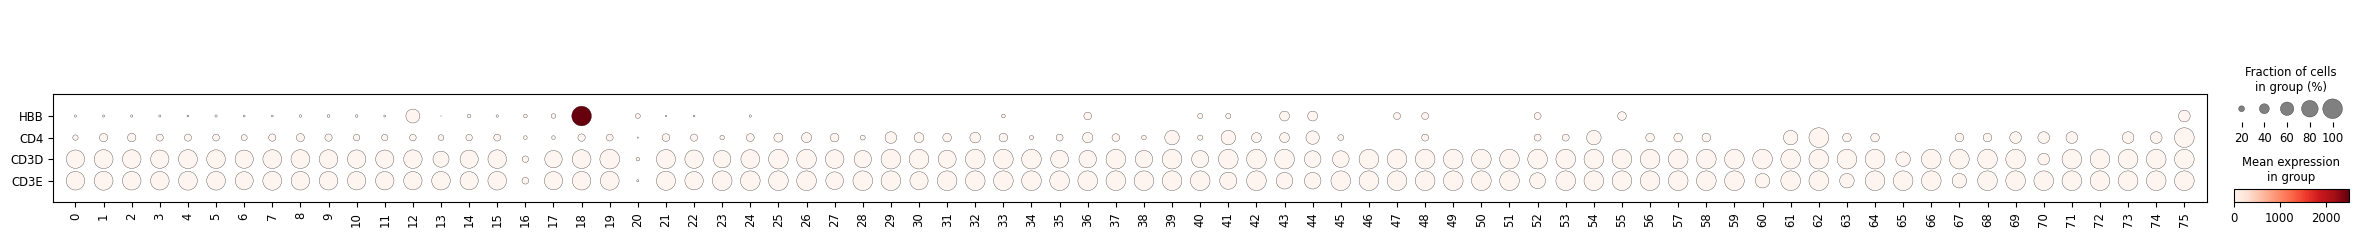

In [45]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['HBB','CD4','CD3D', 'CD3E'], swap_axes = True)

### HBB Selection

Filtering

In [46]:
adata, n_removed = remove_cl(
    adata, 'HBB', 'above', 0.8, 'leiden_2'
)
n_removed

['18']


1107

Reason

In [47]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Low CD3E Selection

Filtering

In [48]:
adata, n_removed = remove_cl(
    adata, 'CD3E', 'below', 0.4, 'leiden_2'
)
n_removed

['16', '20']


8257

Reason

In [49]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Low quality']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [52]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review GZMB- CD27- EM CD4 T cell

### Proposed updates

- Remove high CD79A cluster (18) as B cell doublet  
- Remove high CD8A cluster (12) as Mislabeled  
    - Re-cluster with CD8 cells to assign final clusters
- Remove low marker detection cluster (17) as low-quality

In [53]:
cell_type = 'GZMB- CD27- EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [54]:
type_uuid

'506a449a-10a0-4fd6-a4c7-efe34bb80ee9'

In [55]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [56]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

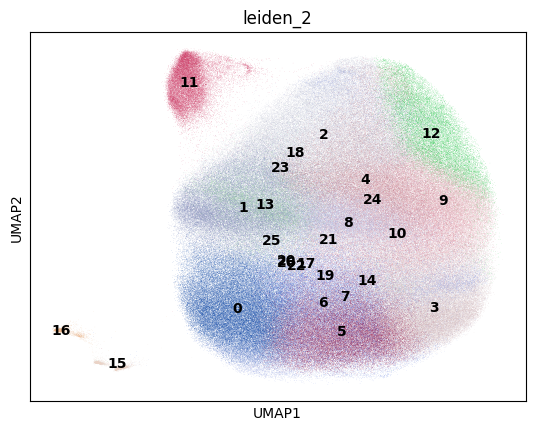

In [57]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

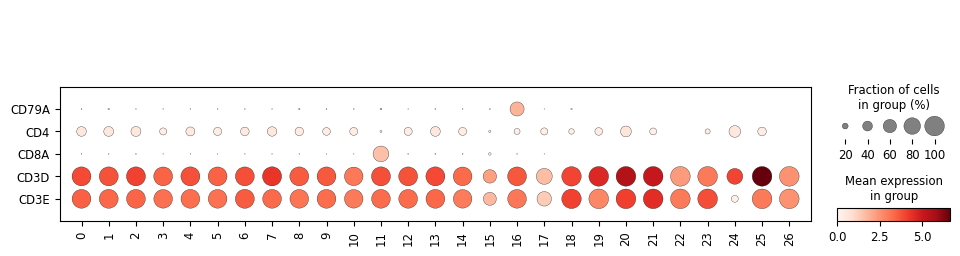

In [58]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','CD3D','CD3E'], swap_axes = True)

### CD79A Selection

Filtering

In [59]:
adata, n_removed = remove_cl(
    adata, 'CD79A', 'above', 0.6, 'leiden_2'
)
n_removed

['16']


2797

Reason

In [60]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['B cell doublet']
    }
)
update_list.append(update_df)

### Low CD3D Selection

Filtering

In [61]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'below', 0.7, 'leiden_2'
)
n_removed

['15']


3180

Reason

In [62]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Low quality']
    }
)
update_list.append(update_df)

### CD8A Selection

Removal

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['11']


Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8+ cells']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [65]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


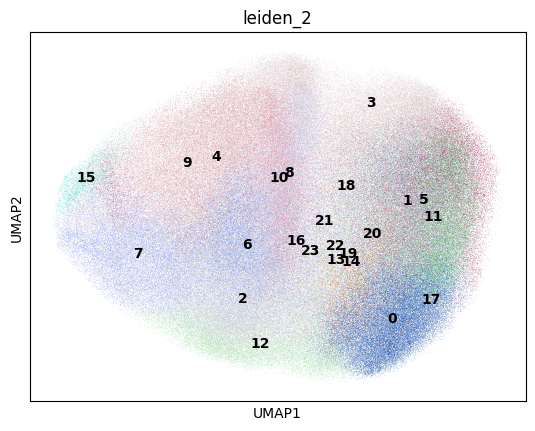

In [66]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [67]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)

In [68]:
out_files.append(out_file)

## Review GZMB- CD27+ EM CD4 T cell

### Proposed updates

- Remove high CD8A cluster (13) as Mislabeled  
    - Re-cluster with CD8 cells to assign final clusters

In [69]:
cell_type = 'GZMB- CD27+ EM CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [70]:
type_uuid

'e42f91dc-c563-4009-a828-6bbfdf1f20b6'

In [71]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [72]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

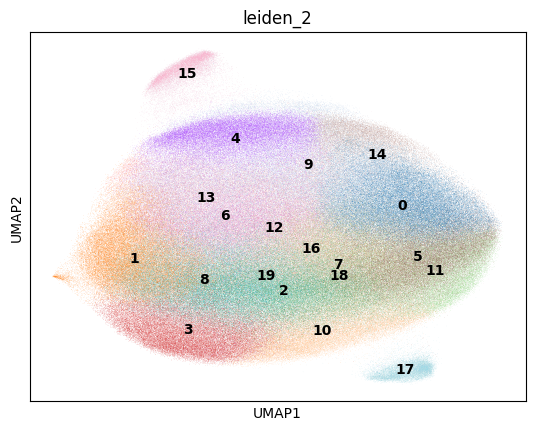

In [73]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

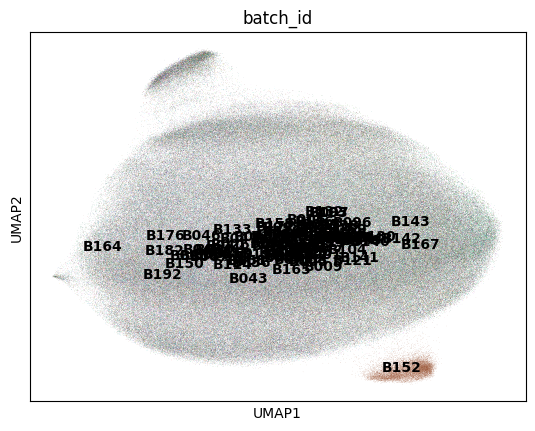

In [74]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

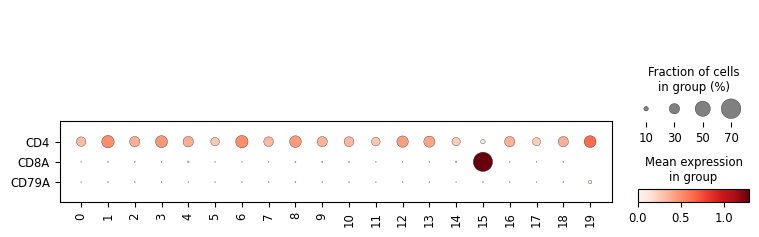

In [75]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD4','CD8A','CD79A'], swap_axes = True)

### CD8A Selection

Removal

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.4, 'leiden_2'
)
n_removed

['15']


17779

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8+ cells']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


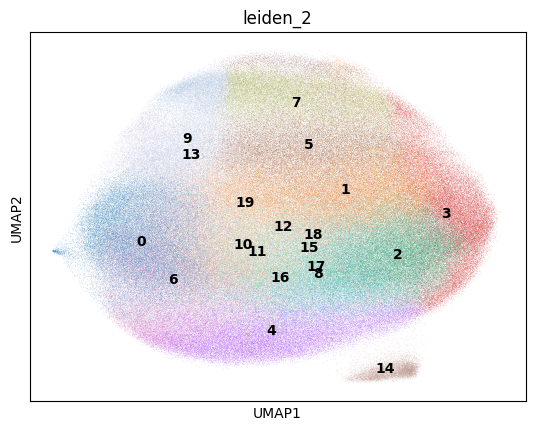

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ISG+ memory CD4 T cell

### Proposed updates

- Remove high CD8A cluster (16) as Mislabeled  
- Remove high FCN1 cluster (23) as Myeloid doublet

In [ ]:
cell_type = 'ISG+ memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'285bbefb-3cc3-4768-b183-33fe47cbd902'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

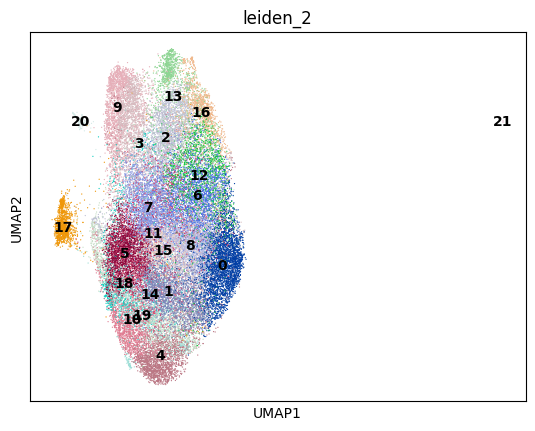

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

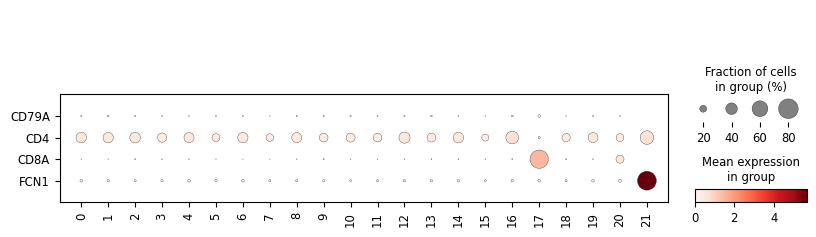

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','FCN1'], swap_axes = True)

### CD8A Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['17', '20']


1308

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8+ cells']
    }
)
update_list.append(update_df)

### FCN1 Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.6, 'leiden_2'
)
n_removed

['21']


37

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


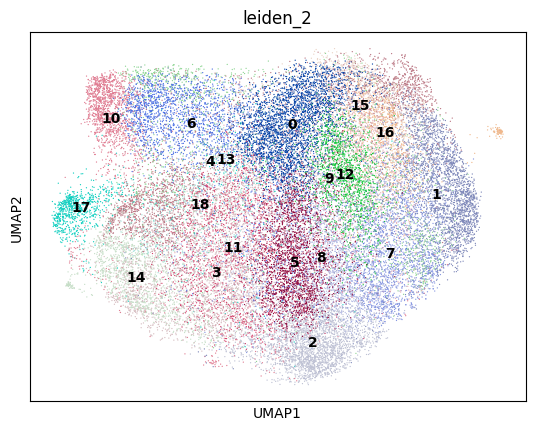

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ISG+ naive CD4 T cell

### Proposed updates

- Remove high CD8A cluster (19) as Mislabeled  

In [ ]:
cell_type = 'ISG+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'1f3d6703-17e5-4bbf-9949-e5f93febc067'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

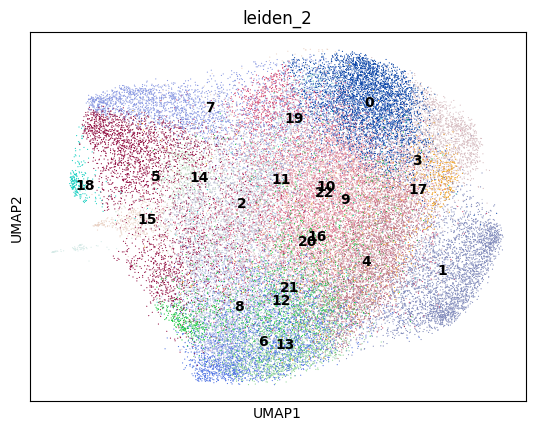

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

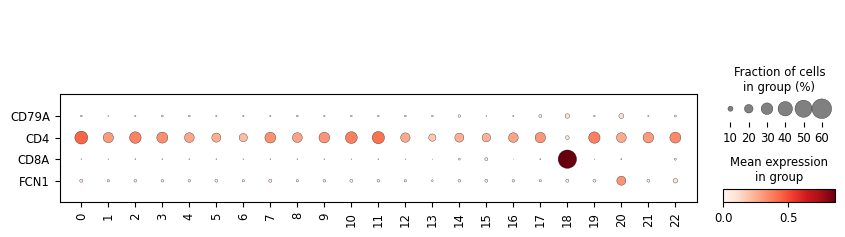

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','FCN1'], swap_axes = True)

### CD8A Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['18']


363

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.1, 'leiden_2'
)
n_removed

['20']


239

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


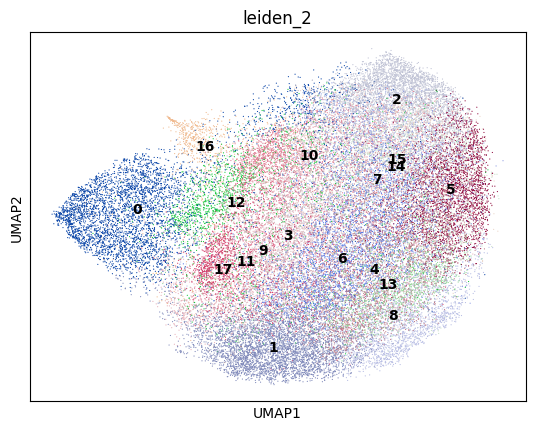

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review KLRF1- GZMB+ CD27- memory CD4 T cell

### Proposed updates

- Remove high CD8A cluster (17) as mislabeled
    - Re-cluster with CD8 cells to assign final clusters

In [ ]:
cell_type = 'KLRF1- GZMB+ CD27- memory CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'd8196be8-1606-47ff-b1e9-3ed08ff18837'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

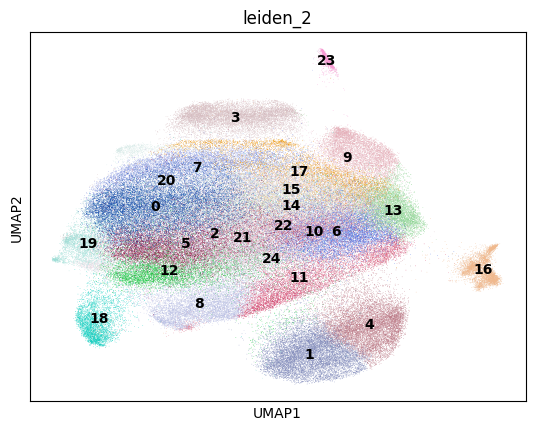

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

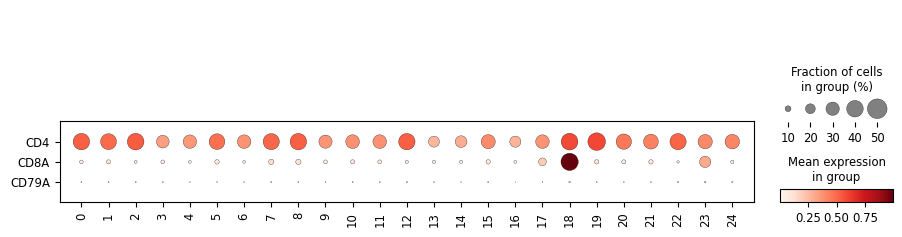

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD4','CD8A','CD79A'], swap_axes = True)

### CD8A Selection

Removal

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['18', '23']


5974

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['reassign'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8+ cells']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; UMAP; Renormalizing


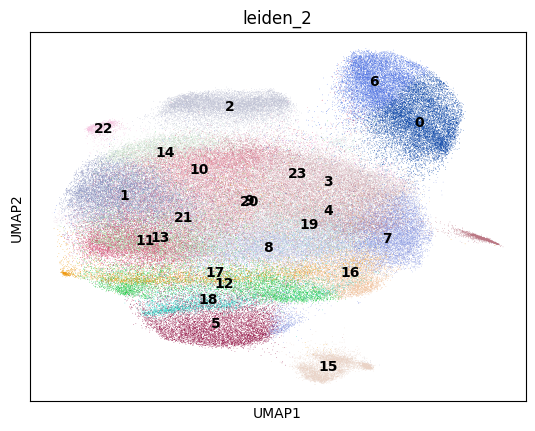

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review SOX4+ naive CD4 T cell

### Proposed updates

- Remove high CD8A cluster (15) as mislabeled
- Remove high TRDC cluster (4) as mislabeled

In [ ]:
cell_type = 'SOX4+ naive CD4 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [ ]:
type_uuid

'96dcc9a0-d880-4a77-930f-de8a4d07bd07'

In [ ]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [ ]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

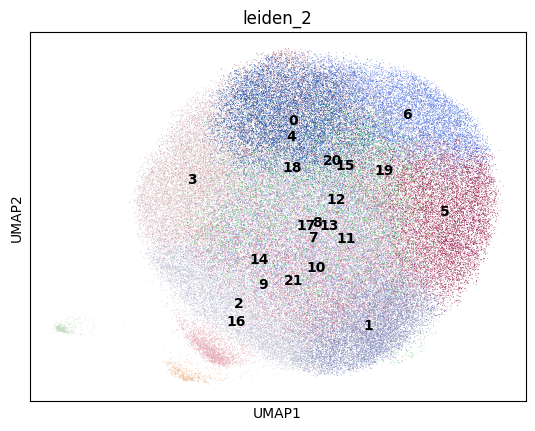

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

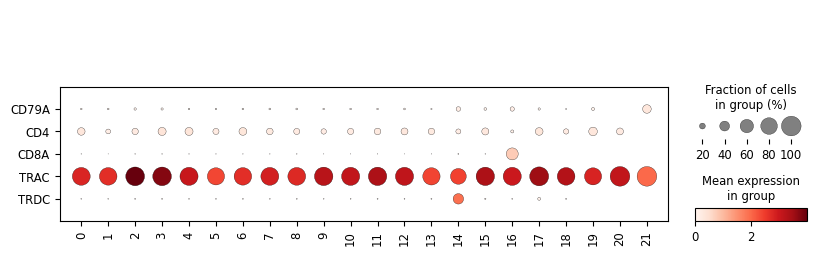

In [ ]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['CD79A','CD4','CD8A','TRAC','TRDC'], swap_axes = True)

### CD8A Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'CD8A', 'above', 0.2, 'leiden_2'
)
n_removed

['16']


1088

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['CD8 doublet']
    }
)
update_list.append(update_df)

### TRDC Selection

Filtering

In [ ]:
adata, n_removed = remove_cl(
    adata, 'TRDC', 'above', 0.2, 'leiden_2'
)
n_removed

['14']


1386

Reason

In [ ]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['gdT doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


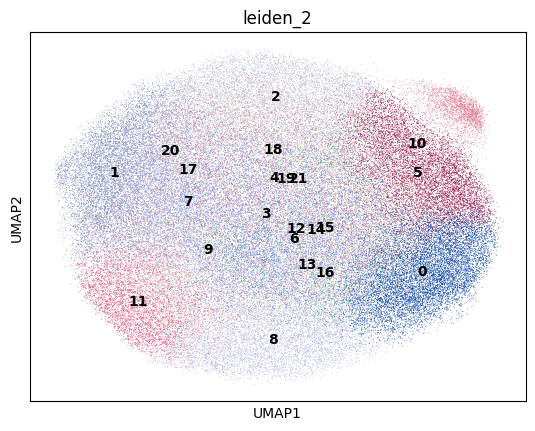

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

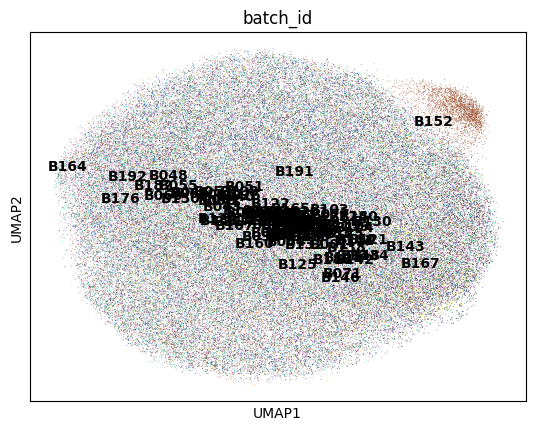

In [ ]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Assemble update reasoning

In [ ]:
update_df = pd.concat(update_list)

In [ ]:
update_df

AIFI_L3 update_type  n_total  n_updated  \
0                         CM CD4 T cell      remove  1424301       4649   
0                         CM CD4 T cell    reassign  1424301      61331   
0                 Core naive CD4 T cell      remove  2708007       1107   
0                 Core naive CD4 T cell      remove  2708007       8257   
0             GZMB- CD27- EM CD4 T cell      remove   533748       2797   
0             GZMB- CD27- EM CD4 T cell      remove   533748       3180   
0             GZMB- CD27- EM CD4 T cell    reassign   533748      27230   
0             GZMB- CD27+ EM CD4 T cell    reassign   608949      17779   
0                ISG+ memory CD4 T cell      remove    36898       1308   
0                ISG+ memory CD4 T cell      remove    36898         37   
0                 ISG+ naive CD4 T cell      remove    43738        363   
0                 ISG+ naive CD4 T cell      remove    43738        239   
0  KLRF1- GZMB+ CD27- memory CD4 T cell    reassign   160888       5974   
0                SOX4+ naive CD4 T cell      remove    99794       1088   
0                SOX4+ naive CD4 T cell      remove    99794       1386   

             change_to  
0          Low quality  
0           CD8+ cells  
0  Erythrocyte doublet  
0          Low quality  
0       B cell doublet  
0          Low quality  
0           CD8+ cells  
0           CD8+ cells  
0           CD8+ cells  
0      Myeloid doublet  
0          CD8 doublet  
0      Myeloid doublet  
0           CD8+ cells  
0          CD8 doublet  
0          gdT doublet

In [ ]:
out_update = 'output/diha_filtered_celltypist_L3_CD4_reasons_{d}.csv'.format(d = date.today())
update_df.to_csv(out_update)
out_files.append(out_update)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [140]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CellTypist L3 CD4 Filtered {d}'.format(d = date.today())

In [141]:
search_id = element_id()
search_id

'mercury-polonium-zinc'

In [142]:
in_files = search_df['id'].tolist()
in_files

['f3a014af-7e16-4671-9da8-01e603bea5ed',
 'abfe5e61-ee6d-47cf-906b-faff06c2ce67',
 '506a449a-10a0-4fd6-a4c7-efe34bb80ee9',
 'e42f91dc-c563-4009-a828-6bbfdf1f20b6',
 '285bbefb-3cc3-4768-b183-33fe47cbd902',
 '1f3d6703-17e5-4bbf-9949-e5f93febc067',
 'd8196be8-1606-47ff-b1e9-3ed08ff18837',
 '96dcc9a0-d880-4a77-930f-de8a4d07bd07']

In [143]:
out_files

['output/diha_filtered_celltypist_L3_CM_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_Core_naive_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_GZMBneg_CD27neg_EM_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_GZMBneg_CD27pos_EM_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_memory_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_ISGpos_naive_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_memory_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_SOX4pos_naive_CD4_T_cell_2024-04-23.h5ad',
 'output/diha_filtered_celltypist_L3_CD4_reasons_2024-04-23.csv']

In [144]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

Cannot determine the current notebook.
1) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12b-Python_filter_L3_cd4_t_cell_data.ipynb
2) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12z-Python_filter_L3_cd4_cd8_transfer.ipynb
3) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/02-reference_labeling/12e-Python_filter_L3_myeloid_data.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/diha_filtered_celltypist_L3_CM_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_Core_naive_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_GZMBneg_CD27neg_EM_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_GZMBneg_CD27pos_EM_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_ISGpos_memory_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_ISGpos_naive_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_memory_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_SOX4pos_naive_CD4_T_cell_2024-04-23.h5ad', 'output/diha_filtered_celltypist_L3_CD4_reasons_2024-04-23.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'd6cfca5b-2def-430c-a084-5cb695ae33a8',
 'files': ['output/diha_filtered_celltypist_L3_CM_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_Core_naive_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_GZMBneg_CD27neg_EM_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_GZMBneg_CD27pos_EM_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_ISGpos_memory_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_ISGpos_naive_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_KLRF1neg_GZMBpos_CD27neg_memory_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_SOX4pos_naive_CD4_T_cell_2024-04-23.h5ad',
  'output/diha_filtered_celltypist_L3_CD4_reasons_2024-04-23.csv']}

In [ ]:
import session_info
session_info.show()